Developments in text and sentiment analysis not only allow us to understand the context and emotion of a large number of opinions but also allow us to analyze the opinions of the customers. Ultimately, they are very helpful for other customers to know other people's opinions on interested products as well. Hence, in this project, I am interested in understanding the word choice used in customer reviews and examining the textual pattern in identifying the rating of the product. My hypothesis is that word choice in customer reviews can be used to identify the rating. 

The textual dataset I am going to work with was obtained from Kaggle (https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews). The dataset contains 23486 entries and 11 columns but I am only going to use two columnns ("Rating" and "Review Text" for most of the time. To tackle the problem more throughly, I will use both supervised and unsupervised learning methods. In the supervised section, given the sentiments are already defined, we will see the accuracy of the rating predicted based on vocabulary.  In the unsupervised section, without pre-assigning customer review text with sentiment, we will see if the clusters that are generated show a significant relationship. 

Here is an outline of steps will be used in this research: (1) Loading Data (2) Data Cleaning (3) Data Exploration (4) Text Processing (5) Supervised Learning Result (6) Unsupervisied Learning Result. 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import re
from nltk.corpus import stopwords 

## Import Data

In [3]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Unnamed: 0                 23486 non-null int64
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [5]:
df.head(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
df = df.drop(columns = 'Unnamed: 0')

In [7]:
df.Rating.value_counts()

5    13131
4     5077
3     2871
2     1565
1      842
Name: Rating, dtype: int64

In [8]:
df['Rating'] = df['Rating'].astype(object)

## Data Cleaning 

In [9]:
df.isnull().any()

Clothing ID                False
Age                        False
Title                       True
Review Text                 True
Rating                     False
Recommended IND            False
Positive Feedback Count    False
Division Name               True
Department Name             True
Class Name                  True
dtype: bool

Since our objective is to do a sentiment analysis and see if the textual feedback from the customers can be used to identify rating, we are only concerned about "Rating", "Review Text", "Class Name" columns. Missing values in the other columns can be dismissed for the purpose of our project. Let's first look at the null values in Review Text column.

In [10]:
#get the index for the null values in Review Text
rev_index = df.loc[df['Review Text'].isnull()].index

In [11]:
#drop the data entries that have null values in Review Text 
df = df.drop(index = rev_index)

In [12]:
df[df['Class Name'].isnull()][["Title","Review Text","Class Name"]]

,Title,Review Text,Class Name
9444,My favorite socks!!!,"I never write reviews, but these socks are so ...",NaN
13767,So soft!,I just love this hoodie! it is so soft and com...,NaN
13768,Wardrobe staple,Love this hoodie. so soft and goes with everyt...,NaN
16216,Warm and cozy,"Just what i was looking for. soft, cozy and warm.",NaN
16221,Love!,I am loving these. they are quite long but are...,NaN
16223,"""long and warm""",These leg warmers are perfect for me. they are...,NaN
18626,Nubby footless tights,"These are amazing quality. i agree, size up to...",NaN
18671,New workhorse,These tights are amazing! if i care for them w...,NaN
20088,Comfy sweatshirt!,This sweatshirt is really nice! it's oversize...,NaN
21532,So worth it!,Got these on sale...absolutely love eberjey! f...,NaN


Even though the above rows are all missing Class Name, we can get a clue of the purchasing products from their respective Review Text (ie. socks, hoodie,tights,sweatshirt,leg warmers).  we will do a contain() method to filter rows with review text that match those purchasing products and see what class they normally fall under.

In [13]:
df[df['Review Text'].str.contains("socks")]["Class Name"].mode()

0    Legwear
dtype: object

In [14]:
df.loc[[23006,23011,22997,9444], "Class Name"] = df.loc[[23006,23011,22997,9444], "Class Name"].fillna('Legwear')

In [15]:
df[df['Review Text'].str.contains("hoodie")]['Class Name'].mode()

0    Lounge
dtype: object

In [16]:
df.loc[[13767,13768], "Class Name"] = df.loc[[13767,13768], "Class Name"].fillna('Lounge')

In [17]:
df.loc[[18626,16223,18671], "Class Name"] = df.loc[[18626,16223, 18671], "Class Name"].fillna('Legwear')

In [18]:
df = df.drop(index = 16216)

In [19]:
df[df['Review Text'].str.contains("sweatshirt")]['Class Name'].mode()

0    Knits
dtype: object

In [20]:
df.loc[20088, "Class Name"] = "Knits"

In [21]:
df = df.drop(index = [16221, 21532])

## Data Exploration 

In [22]:
df['Class Name'].value_counts()

Dresses           6145
Knits             4627
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1104
Fine gauge        1059
Skirts             903
Jackets            683
Lounge             671
Swim               332
Outerwear          319
Shorts             304
Sleep              214
Legwear            165
Intimates          147
Layering           132
Trend              118
Casual bottoms       1
Chemises             1
Name: Class Name, dtype: int64

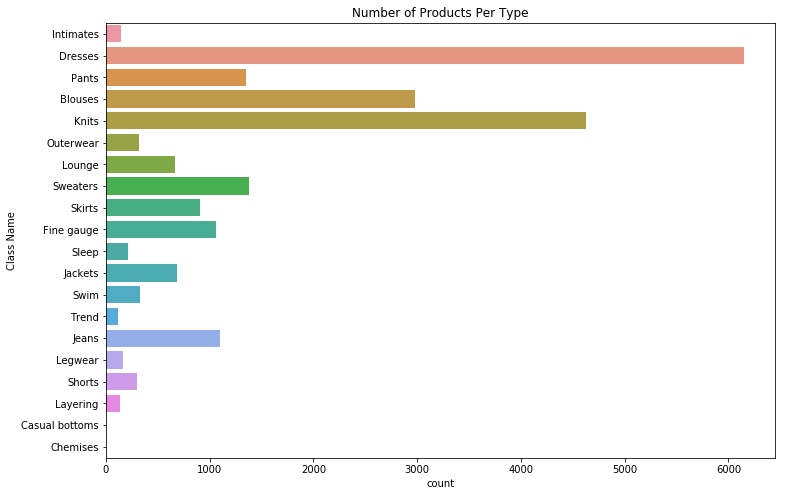

In [23]:
plt.figure(figsize=(12,8))
sns.countplot(y="Class Name",data=df)
plt.title("Number of Products Per Type")
plt.show()

It seems like people with dresses, knits, and blouses purchased left the most reviews. 

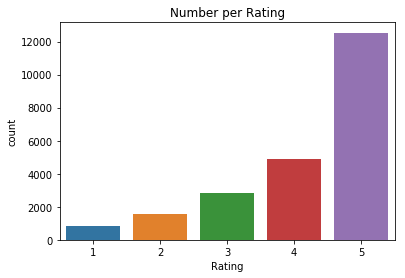

In [24]:
sns.countplot(x = 'Rating', data = df)
plt.title("Number per Rating")
plt.show()

This shows a general satisfaction of the products from the customers. Most people gave a rating of 3 and up.  

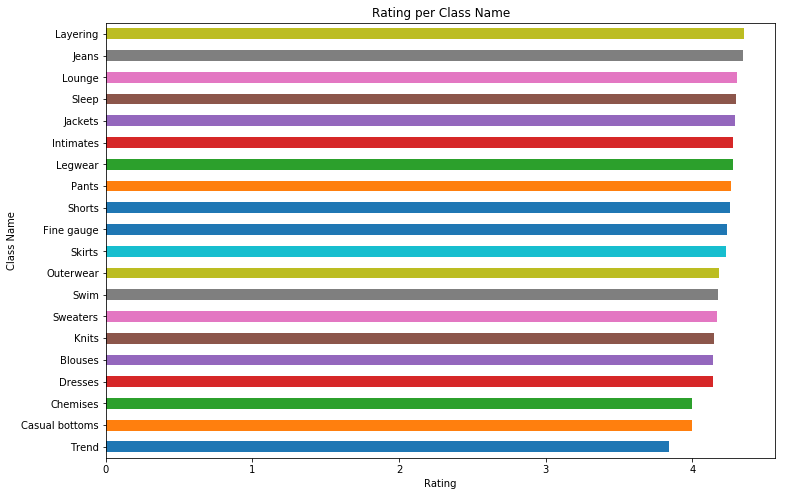

In [25]:
df_copy = df.copy()
df_copy['Rating'] = df_copy['Rating'].astype(int)

product_grouped = df_copy.groupby("Class Name")["Rating"].mean().sort_values()

plt.figure(figsize=(12,8))
product_grouped.plot(kind='barh', x='Class Name', y='Rating')
plt.xlabel('Rating')
plt.title("Rating per Class Name")
plt.show()

Since the average rating per product type is similar, this means that rating scores are not mainly related with the type of products. Or we can't say that, one type of product is better than the other.

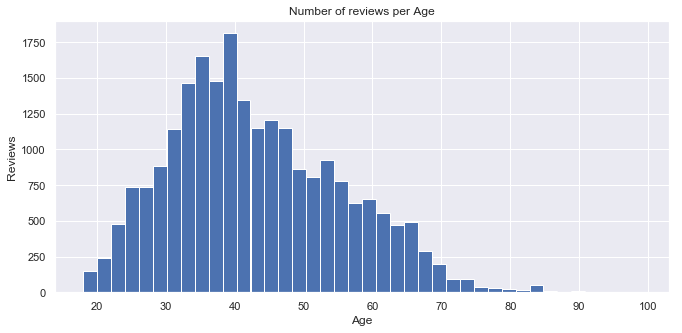

In [26]:
sns.set(rc={'figure.figsize':(11,5)})
plt.hist(df.Age, bins=40)
plt.xlabel('Age')
plt.ylabel('Reviews')
plt.title('Number of reviews per Age')
plt.show()

Seems like people in age group 25-50 are more prone to give reviews than others.

1    18537
0     4101
Name: Recommended IND, dtype: int64


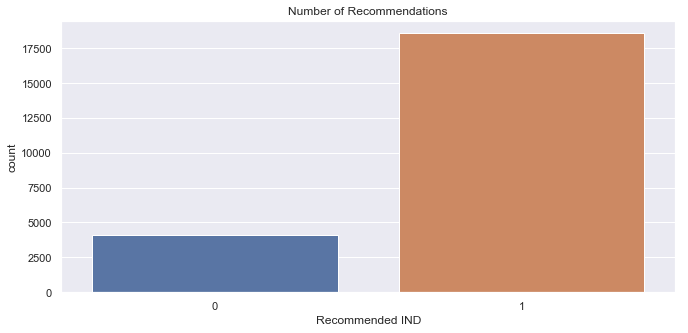

In [27]:
print(df['Recommended IND'].value_counts())

sns.countplot(x ="Recommended IND",data=df)
plt.title("Number of Recommendations")
plt.show()

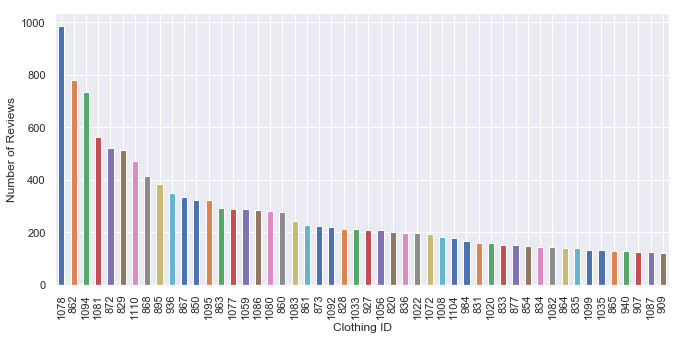

In [28]:
df['Clothing ID'].value_counts()[:50].plot(kind='bar')

plt.xlabel("Clothing ID")
plt.ylabel("Number of Reviews")
plt.show()

1078 is the most popular item for reviews. 

## Textual Cleaning 

In [29]:
import nltk
nltk.download('stopwords')
df['Review Text'] = df['Review Text'].apply(lambda x: x.lower())
df['Review Text'] = df['Review Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

#split the string by words
df['Review Text'] = df['Review Text'].apply(lambda x: x.split())

print(df['Review Text'].head(5))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shuyinwu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [absolutely, wonderful, silky, and, sexy, and,...
1    [love, this, dress, its, sooo, pretty, i, happ...
2    [i, had, such, high, hopes, for, this, dress, ...
3    [i, love, love, love, this, jumpsuit, its, fun...
4    [this, shirt, is, very, flattering, to, all, d...
Name: Review Text, dtype: object


In [30]:
stop_words = set(stopwords.words('english')) 

df['Review Text'] = df['Review Text'].apply(lambda x: [item for item in x if item not in stop_words])

print(df['Review Text'].head(5))

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happened, find, st...
2    [high, hopes, dress, really, wanted, work, ini...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flattering, due, adjustable, front, ti...
Name: Review Text, dtype: object


In [31]:
import nltk
nltk.download('wordnet')
def lemmatize():
    lemmatizer = nltk.stem.WordNetLemmatizer()
    df['lemmatized'] = df['Review Text'].apply(
    lambda row: list(map(lemmatizer.lemmatize,row)))
    return(df['lemmatized'].head())

print(lemmatize())

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shuyinwu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happened, find, st...
2    [high, hope, dress, really, wanted, work, init...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flattering, due, adjustable, front, ti...
Name: lemmatized, dtype: object


In [32]:
#from nltk.stem.porter import PorterStemmer
#ps=PorterStemmer()
#df['stemmed'] = df["lemmatized"].apply(lambda x: [ps.stem(y) for y in x])

#print(df['stemmed'].head())

Since the dataset does not have a column that shows sentiment as positive or negative, I will create a new sentiment column. To do this, I will assume the reviews which has 4 or higher rating as positive (True) and 2 or lower rating as negative (False). Also, I am not going to include data with a rating of 3.

In [33]:
df = df.drop(index = df[df['Rating'] == 3].index)

In [34]:
df['is_positive'] = df['Rating'].apply(lambda x: 1 if x >= 3 else 0)

In [35]:
df['joined_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))
positive_text = df[df['is_positive'] == 1]['joined_text'].values
neg_text = df[df['is_positive'] == 0]['joined_text'].values

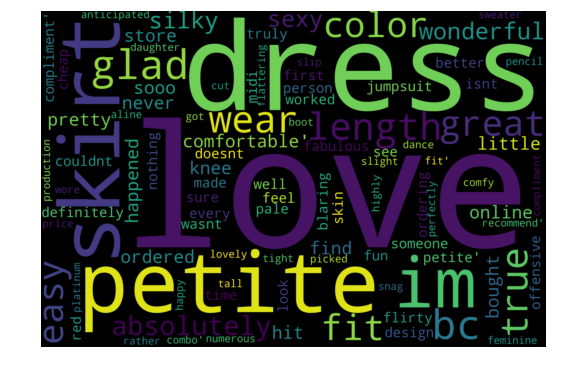

In [36]:
#display the most common words in review text 
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(positive_text))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

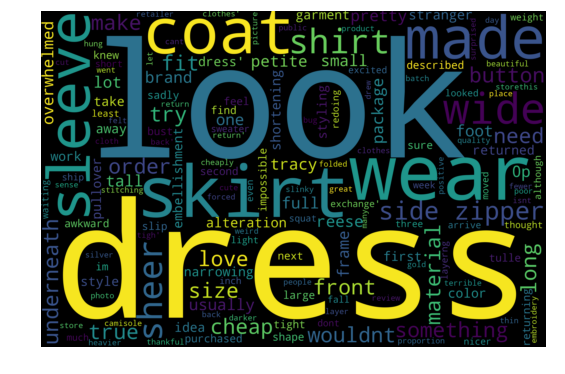

In [37]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(neg_text))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Supervised Machine Learning Results

**Random Forest Regressor**

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df=1.0, min_df=0.2)
X = df['joined_text']
Y = df['is_positive']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

cv.fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

X_train_array = X_train_cv.toarray()
X_text_array = X_test_cv.toarray()

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()

scores = cross_val_score(rf, X_train_array, Y_train, cv=3)

print(scores)

[0.85960265 0.86733535 0.85917093]


/Users/shuyinwu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/shuyinwu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/shuyinwu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [{'n_estimators' : [100,150,200],
            'max_depth': [5,15,10]
              }]
gridCV = GridSearchCV(estimator=rf, param_grid=param_grid,cv=3,n_jobs=-1)
gridCV = gridCV.fit(X_train_array, Y_train)
print(gridCV.best_score_)
print(gridCV.best_params_)

0.8790058036840778
{'max_depth': 5, 'n_estimators': 100}


**Gradient Boosting**

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

gb = GradientBoostingClassifier()
scores = cross_val_score(rf, X_train_array, Y_train, cv=3)

print(scores)

[0.85865658 0.86733535 0.85917093]


/Users/shuyinwu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/shuyinwu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/shuyinwu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_grid = [{'learning_rate': [0.1, 0.05, 0.01], 'n_estimators': [150], 'min_samples_leaf':[5,10,15]}]
gridCV = GridSearchCV(estimator=gb, param_grid=param_grid,cv=3,n_jobs=-1)
gridCV = gridCV.fit(X_train_array, Y_train)
print(gridCV.best_score_)
print(gridCV.best_params_)

0.8790058036840778
{'learning_rate': 0.01, 'min_samples_leaf': 5, 'n_estimators': 150}


## Clustering 

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
kmeans = KMeans(n_clusters = 2)


k_means = kmeans.fit(X_train_array)

confusion_matrix(Y_train,k_means.labels_)


array([[  294,  1624],
       [ 1884, 12050]])

In my future project, I want to try different advanced encoding techniques (tf-idf and word2vec) Or different clustering techniques to see if there is an improvement on clustering. 

Current clustering is not promising. Ideally, we would like to see two clusters. However, based on the confusion matrix for K means clustering with n_clusters = 2, datapoints with higher values 91624 AND 12050) didn't go to different clusters. Majority of the points goes to the same cluster. 